### Problem statement : Clustering product ids
### Objective: The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.

<img src="ClusteringImage2.png" height="400" width="400"/>

In [29]:
import pandas as pd
import numpy as np

In [30]:
base_dataset=pd.read_csv("C:\\Sridhar\\AI_ML\\Algorithms\\datasets\\order_products__train.csv")

In [31]:
base_dataset.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [32]:
base_dataset.shape

(1048575, 4)

## Pre-processing
### Step 1 : Memory_management

In [33]:
    df=base_dataset
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype

        if col_type in [int,float]:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    print("*******************************************************************************************")
    base_dataset=df

Memory usage of dataframe is 32.00 MB
Memory usage after optimization is: 32.00 MB
Decreased by 0.0%
*******************************************************************************************


In [34]:
df=base_dataset

In [35]:
## Following command will fetch only numberical columns

In [36]:
df=df[df.describe().columns]

In [37]:
df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [38]:
master_dataset=df[['product_id','order_id','add_to_cart_order','reordered']]

In [39]:
master_dataset.head()

,product_id,order_id,add_to_cart_order,reordered
0,49302,1,1,1
1,11109,1,2,1
2,10246,1,3,0
3,49683,1,4,0
4,43633,1,5,1


In [40]:
master_dataset.shape

(1048575, 4)

In [41]:
master_dataset['product_id'].nunique()

36864

In [42]:
master_dataset=master_dataset.groupby('product_id').sum()

In [43]:
master_dataset.shape

(36864, 3)

In [44]:
master_dataset.head()

,order_id,add_to_cart_order,reordered
product_id,,,
1,62715496,356,37
2,5486869,46,1
3,6266241,14,5
4,25854519,167,12
5,1854678,5,1


In [45]:
master_dataset.reset_index(inplace=True)

In [46]:
master_dataset.head()

,product_id,order_id,add_to_cart_order,reordered
0,1,62715496,356,37
1,2,5486869,46,1
2,3,6266241,14,5
3,4,25854519,167,12
4,5,1854678,5,1


## null value treatement
## Outlier treatement
## MinMaxScalar

In [47]:
master_dataset.isna().sum()

product_id           0
order_id             0
add_to_cart_order    0
reordered            0
dtype: int64

In [48]:
def null_values(base_dataset):
    print(base_dataset.isna().sum())
    ## null value percentage     
    null_value_table=(base_dataset.isna().sum()/base_dataset.shape[0])*100
    ## null value percentage beyond threshold drop , else treat the columns 
    
    retained_columns=null_value_table[null_value_table<int(input())].index
    # if any variable as null value greater than input(like 30% of the data) value than those variable are consider as drop
    drop_columns=null_value_table[null_value_table>int(input())].index
    base_dataset.drop(drop_columns,axis=1,inplace=True)
    len(base_dataset.isna().sum().index)
    cont=base_dataset.describe().columns
    cat=[i for i in base_dataset.columns if i not in base_dataset.describe().columns]
    for i in cat:
        base_dataset[i].fillna(base_dataset[i].value_counts().index[0],inplace=True)
    for i in cont:
        base_dataset[i].fillna(base_dataset[i].median(),inplace=True)
    print(base_dataset.isna().sum())
    return base_dataset,cat,cont

In [25]:
master_dataset=null_values(master_dataset)

product_id           0
order_id             0
add_to_cart_order    0
reordered            0
dtype: int64
30
30
product_id           0
order_id             0
add_to_cart_order    0
reordered            0
dtype: int64


In [26]:
def outliers_transform(base_dataset):
    for i in base_dataset.var().sort_values(ascending=False).index[1:10]:
        x=np.array(base_dataset[i])
        qr1=np.quantile(x,0.25)
        qr3=np.quantile(x,0.75)
        iqr=qr3-qr1
        utv=qr3+(1.5*(iqr))
        ltv=qr1-(1.5*(iqr))
        y=[]
        for p in x:
            if p <ltv or p>utv:
                y.append(np.median(x))
            else:
                y.append(p)
        base_dataset[i]=y

In [27]:
master_dataset=outliers_transform(master_dataset)

AttributeError: 'tuple' object has no attribute 'var'

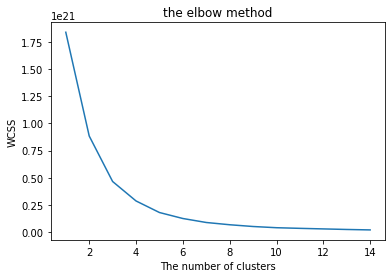

In [49]:
import matplotlib.pyplot as plt
import sklearn as sklearn
from sklearn.cluster import KMeans
x = []
for i in range(1,15):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(master_dataset[['order_id','add_to_cart_order','reordered']])
    x.append(kmeans.inertia_)

plt.plot(range(1,15),x)
plt.title('the elbow method')
plt.xlabel('The number of clusters')
plt.ylabel('WCSS')
plt.show()

In [50]:
from sklearn.cluster import KMeans
km=KMeans(n_clusters=2)
km.fit(master_dataset[['order_id','add_to_cart_order','reordered']])
km.predict(master_dataset[['order_id','add_to_cart_order','reordered']])
km.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [52]:
km.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [51]:
master_dataset['clusters']=km.labels_
master_dataset

,product_id,order_id,add_to_cart_order,reordered,clusters
0,1,62715496,356,37,0
1,2,5486869,46,1,0
2,3,6266241,14,5,0
3,4,25854519,167,12,0
4,5,1854678,5,1,0
5,8,17680473,117,6,0
6,9,3198314,13,2,0
7,10,117082537,809,55,0
8,11,3216314,27,1,0
9,12,15940659,90,4,0


In [153]:
from sklearn.cluster import AgglomerativeClustering
ag=AgglomerativeClustering(n_clusters=2)
ag.fit(master_dataset[['order_id','add_to_cart_order','reordered']])
km.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [154]:
master_dataset['clusters']=km.labels_
master_dataset

,product_id,order_id,add_to_cart_order,reordered,clusters
0,1,62715496,356,37,0
1,2,5486869,46,1,0
2,3,6266241,14,5,0
3,4,25854519,167,12,0
4,5,1854678,5,1,0
5,8,17680473,117,6,0
6,9,3198314,13,2,0
7,10,117082537,809,55,0
8,11,3216314,27,1,0
9,12,15940659,90,4,0
